# Data Retrieval

This may not work on windows so just use the extracted NIPS papers data from the __`nipstxt/`__ folder present in the same directory as this notebook which already has the data pre-downloaded and extracted

In [1]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

'wget' is not recognized as an internal or external command,
operable program or batch file.


# Data Extraction

In [2]:
!tar -xzf nips12raw_str602.tgz

tar: Error opening archive: Failed to open 'nips12raw_str602.tgz'


# Load and Pre-process Data

In [6]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'
print(os.listdir(DATA_PATH))

['idx', 'MATLAB_NOTES', 'nips00', 'nips01', 'nips02', 'nips03', 'nips04', 'nips05', 'nips06', 'nips07', 'nips08', 'nips09', 'nips10', 'nips11', 'nips12', 'nips12raw_str602', 'nips16_01.txt', 'nips16_02.txt', 'nips16_03.txt', 'nips16_04.txt', 'orig', 'RAW_DATA_NOTES', 'README_yann']


In [4]:
# Read all texts into a list.
# Each paper is in its own text file, hence we need to use file-reading functions from Python.
papers = []

file_names = os.listdir(DATA_PATH)
for file_name in file_names:
    with open(DATA_PATH + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
    papers.append(data)
len(papers)

PermissionError: [Errno 13] Permission denied: 'nipstxt/idx'

In [5]:
# look at a fragment of text from one of the research papers to get an idea.
print(papers[0][:1000])

IndexError: list index out of range

## Basic Text Wrangling (preprocessing)
We keep things simple here and perform tokenization, lemmatizing nouns, and removing stopwords and any terms having a single character.

In [4]:
%%time
import nltk

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

NameError: name 'papers' is not defined

In [47]:
# viewing a processed paper
print(norm_papers[0][:50])

['nipstxt', 'ustar', 'roweis', 'rowegrp', 'nipstxt', 'nips00', 'ustar', 'roweis', 'rowegrp', 'nipstxt', 'nips00', 'txt', 'ustar', 'roweis', 'rowegrp', 'neural', 'net', 'traditional', 'classifier', 'william', 'huang', 'richard', 'lippmann', 'mit', 'lincoln', 'laboratory', 'lexington', 'usa', 'abstract', 'previous', 'work', 'net', 'continuous', 'valued', 'input', 'led', 'generative', 'procedure', 'construct', 'convex', 'decision', 'region', 'two', 'layer', 'percepttons', 'one', 'hidden', 'layer', 'arbitrary', 'decision']


# Text Representation with Feature Engineering
## gensim:
Τhis framework was built for topic modeling.
We can do amazing things with this framework, including text  similarity, semantic analytics, topic models, and text summarization. 

Besides this, Gensim offers a lot of capabilities and more flexibility than Scikit-Learn to build, evaluate, and tune topic models, which we will see very shortly. We build topic models using the following methods in this section.

• Latent Semantic Indexing (LSI)
• Latent Dirichlet Allocation (LDA)

In [48]:
# Before feature engineering and vectorization, we want to extract some useful bi-gram
# based phrases from our research papers and remove some unnecessary terms.
import gensim

# We start by extracting and generating words and bi-grams as phrases for
# each tokenized research paper. We can build this phrase generation model easily with
# the following code and test it on a sample paper.

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

# we have single words as well as bi-grams (two words separated by an underscore

['nipstxt', 'ustar_roweis', 'rowegrp', 'nipstxt_nips00', 'ustar_roweis', 'rowegrp', 'nipstxt_nips00', 'txt_ustar', 'roweis_rowegrp', 'neural_net', 'traditional', 'classifier', 'william', 'huang', 'richard_lippmann', 'mit_lincoln', 'laboratory', 'lexington', 'usa_abstract', 'previous_work', 'net', 'continuous_valued', 'input', 'led', 'generative', 'procedure', 'construct', 'convex', 'decision_region', 'two', 'layer_percepttons', 'one', 'hidden_layer', 'arbitrary', 'decision_region', 'three', 'layer_percepttons', 'two', 'hidden_layer', 'demonstrate', 'two', 'layer', 'perceptton', 'classifier', 'trained', 'back_propagation', 'form', 'convex', 'disjoint', 'decision_region']


In [55]:
# Let’s generate phrases for all our tokenized research papers and build a vocabulary
# that will help us obtain a unique term/phrase to number mapping
# (since machine ordeep learning only works on numeric tensors).

norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '000000e'), (1, '000b'), (2, '000branches'), (3, '000d'), (4, '000na'), (5, '000p'), (6, '000th'), (7, '000training'), (8, '001000_'), (9, '0016a'), (10, '002o'), (11, '002t'), (12, '00425z'), (13, '005m'), (14, '005r')]
Total Vocabulary Size: 80976


In [56]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# We removed all terms that occur fewer than 20 times across all documents and all
# terms that occur in more than 60% of all the documents. We are interested in finding
# different themes and topics and not recurring themes.

## dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 80976


In [57]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(189, 2), (981, 1), (1222, 1), (1268, 4), (2002, 1), (2157, 1), (2815, 1), (4646, 1), (4703, 4), (4718, 1), (4785, 1), (4975, 1), (5050, 1), (5074, 1), (5174, 1), (5223, 1), (5224, 1), (5245, 1), (5263, 1), (5270, 1), (5341, 1), (5360, 1), (5366, 1), (5549, 1), (5726, 1), (5804, 1), (5895, 1), (6069, 1), (6213, 18), (6356, 1), (6445, 2), (6452, 7), (6490, 1), (6491, 1), (6495, 1), (6528, 3), (6614, 1), (6682, 1), (6763, 1), (6777, 1), (6796, 1), (6917, 1), (7165, 1), (7410, 2), (7415, 1), (7424, 2), (7448, 3), (7453, 3), (7466, 1), (7490, 4)]


In [58]:
# viewing actual terms and their counts
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('0k', 2), ('1a', 1), ('1the', 1), ('1y', 4), ('2this', 1), ('30th', 1), ('4this', 1), ('able', 1), ('absolute', 4), ('abstract', 1), ('accelerated', 1), ('acknowledgement_research', 1), ('across', 1), ('acting', 1), ('adam', 1), ('add', 1), ('added', 1), ('additional', 1), ('address', 1), ('addressed', 1), ('adjusts', 1), ('admit', 1), ('admitting', 1), ('affect', 1), ('agree', 1), ('ai_bi', 1), ('aim', 1), ('ala', 1), ('algorithm', 18), ('allows', 1), ('already', 2), ('also', 7), ('alternative', 1), ('alternatively', 1), ('although', 1), ('always', 3), ('amenable', 1), ('amount', 1), ('analogously', 1), ('analysis', 1), ('analyzed', 1), ('andreas', 1), ('answered', 1), ('appear', 2), ('appears', 1), ('appendix', 2), ('applicable', 3), ('application', 3), ('apply', 1), ('approach', 4)]


In [59]:
# total papers in the corpus
print('Total number of papers:', len(bow_corpus))

Total number of papers: 5


Our documents are now processed and have a good enough representation with the
Bag of Words model to begin modeling.
# Topic Models with Latent Semantic Indexing (LSI)
A statistical technique to correlate semantically linked terms from corpora. 
Uses Singular Value Decomposition (SVD) technique.
The main principle behind LSI is that similar terms tend to be used in the same context and hence tend to co-occur more.
Ability to uncover latent hidden terms that correlate semantically to form topics.

It is quite simple to build this model, thanks to Gensim’s clean and concise API (gensim.models.LsiModel).

In [60]:
%%time

TOTAL_TOPICS = 10 # We have explicitly set the number of topics to 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS,
                                 onepass=True, chunksize=1740, power_iters=1000)

Wall time: 16min 45s


In [63]:
# Once the model is built, we can view the major topics or themes in our corpus by
# using the following code.
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.275*"network" + 0.254*"model" + 0.202*"learning" + 0.196*"input" + 0.168*"function" + 0.151*"system" + 0.151*"one" + 0.142*"data" + 0.142*"set" + 0.140*"algorithm" + 0.132*"time" + 0.131*"training" + 0.128*"output" + 0.124*"using" + 0.121*"wa" + 0.119*"two" + 0.112*"value" + 0.111*"weight" + 0.107*"state" + 0.107*"result"

Topic #2:
0.323*"state" + -0.240*"image" + 0.221*"algorithm" + 0.215*"function" + 0.206*"policy" + 0.194*"observation" + -0.182*"network" + -0.164*"caption" + 0.164*"model" + 0.152*"sample" + 0.144*"reinforcement_learning" + 0.135*"action" + 0.132*"assumption" + 0.113*"exploration" + 0.112*"complexity" + -0.104*"word" + -0.096*"data" + 0.091*"pomdps" + -0.090*"audio" + -0.087*"input"

Topic #3:
-0.494*"image" + -0.360*"caption" + -0.197*"audio" + -0.183*"word" + -0.149*"model" + -0.145*"color" + 0.127*"input" + -0.117*"segmentation" + -0.108*"similarity" + -0.107*"spoken" + 0.096*"output" + -0.091*"text" + -0.088*"spectrogram" + -0.084*"embedding" + -0.08

Based on existing research and interpretations, considering we are reducing
the dimensionality here to a 10-dimensional space based on the number of topics, the sign on each term indicates a sense of direction or orientation in the vector space for a particular topic. The higher the weight, the more important the contribution. So similar correlated terms have the same sign or direction. 

Hence, it is perfectly possible for a topic to have two different sub-themes based on the sign or orientation of terms.

In [64]:
# separate these terms and try to interpret the topics again
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()
    

Topic #1:
Direction 1: [('network', 0.275), ('model', 0.254), ('learning', 0.202), ('input', 0.196), ('function', 0.168), ('system', 0.151), ('one', 0.151), ('data', 0.142), ('set', 0.142), ('algorithm', 0.14), ('time', 0.132), ('training', 0.131), ('output', 0.128), ('using', 0.124), ('wa', 0.121), ('two', 0.119), ('value', 0.112), ('weight', 0.111), ('state', 0.107), ('result', 0.107)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('state', 0.323), ('algorithm', 0.221), ('function', 0.215), ('policy', 0.206), ('observation', 0.194), ('model', 0.164), ('sample', 0.152), ('reinforcement_learning', 0.144), ('action', 0.135), ('assumption', 0.132), ('exploration', 0.113), ('complexity', 0.112), ('pomdps', 0.091)]
--------------------------------------------------
Direction 2: [('image', -0.24), ('network', -0.182), ('caption', -0.164), ('word', -0.104), ('data', -0.096), ('audio', -0.09), ('i

In [65]:
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

((80976, 5), (5,), (5, 5))

In [68]:
TOTAL_TOPICS = 5
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5
0,1.000,-0.001,0.001,0.000,0.000
1,0.001,0.316,-0.317,-0.847,0.287
2,0.001,0.850,-0.320,0.411,-0.077
3,0.001,-0.137,-0.405,-0.198,-0.882
4,0.001,-0.399,-0.795,0.273,0.366


In [71]:
# document_numbers = [13, 250, 500]
document_numbers = [1, 3, 4]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()
    
# the LSI model is quite effective, although a tad difficult to
# interpret based on the positive and negative weights, which often make things confusing

Document #1:
Dominant Topics (top 3): ['T4', 'T3', 'T2']
Paper Summary:
Cooperative Graphical Models
Josip Djolonga
Dept. of Computer Science, ETH Zurich ¨
josipd@inf.ethz.ch
Stefanie Jegelka
CSAIL, MIT
stefje@mit.edu
Sebastian Tschiatschek
Dept. of Computer Science, ETH Zurich ¨
stschia@inf.ethz.ch
Andreas Krause
Dept. of Computer Science, ETH Zurich ¨
krausea@inf.ethz.ch
Abstract
We study a rich family of distributions that capture variable interactions significantly more expressive than those representable with low-treewidth or pairwise
graphical models, or log-s

Document #3:
Dominant Topics (top 3): ['T5', 'T3', 'T4']
Paper Summary:
Automated scalable segmentation of neurons from
multispectral images
Uygar Sümbül
Grossman Center for the Statistics of Mind
and Dept. of Statistics, Columbia University
Douglas Roossien Jr.
University of Michigan Medical School
Fei Chen
MIT Media Lab and McGovern Institute
Nicholas Barry
MIT Media Lab and McGovern Institute
Edward S. Boyden
MIT Media 

# Implementing LSI Topic Models from Scratch
Match the previous topic model’s output from Gensim very closely.
The heart of LSI models involves Singular Value Decomposition (SVD).
SVD is a very powerful mathematical operation and we will see more of this during document summarization.

In [72]:
td_matrix = gensim.matutils.corpus2dense(corpus=bow_corpus, num_terms=len(dictionary))
print(td_matrix.shape)
td_matrix

(80976, 5)


array([[4., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 2.]], dtype=float32)

In [73]:
vocabulary = np.array(list(dictionary.values()))
print('Total vocabulary size:', len(vocabulary))
vocabulary

Total vocabulary size: 80976


array(['000000e', '000b', '000branches', ..., 'vinyals', 'website',
       'zitnick'], dtype='<U71')

In [77]:
dictionary[0]

'000000e'

In [78]:
from scipy.sparse.linalg import svds

u, s, vt = svds(td_matrix, k=TOTAL_TOPICS, maxiter=10000)
term_topic = u
singular_values = s
topic_document = vt
term_topic.shape, singular_values.shape, topic_document.shape

ValueError: k must be between 1 and min(A.shape), k=5

In [24]:
tt_weights = term_topic.transpose() * singular_values[:, None]
tt_weights.shape

(10, 7756)

In [25]:
top_terms = 20
topic_key_term_idxs = np.argsort(-np.absolute(tt_weights), axis=1)[:, :top_terms]
topic_keyterm_weights = np.array([tt_weights[row, columns] 
                             for row, columns in list(zip(np.arange(TOTAL_TOPICS), topic_key_term_idxs))])
topic_keyterms = vocabulary[topic_key_term_idxs]
topic_keyterms_weights = list(zip(topic_keyterms, topic_keyterm_weights))
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    terms, weights = topic_keyterms_weights[n]
    term_weights = sorted([(t, w) for t, w in zip(terms, weights)], 
                          key=lambda row: -abs(row[1]))
    for term, wt in term_weights:
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('training', 92.618), ('task', 80.732), ('pattern', 70.619), ('classifier', 56.989), ('control', 50.677), ('rule', 45.926), ('action', 41.202), ('neuron', 38.193)]
--------------------------------------------------
Direction 2: [('word', -188.488), ('vector', -85.973), ('node', -54.376), ('recognition', -53.232), ('sequence', -50.351), ('circuit', -45.394), ('cell', -44.811), ('hmm', -34.086), ('character', -34.022), ('chip', -32.16), ('matrix', -32.093), ('structure', -30.993)]
--------------------------------------------------

Topic #2:
Direction 1: [('word', 78.347), ('neuron', 69.793), ('stimulus', 63.234), ('feature', 53.819), ('distribution', 53.119), ('response', 30.954), ('state', 29.343), ('probability', 29.099), ('estimate', 28.908)]
--------------------------------------------------
Direction 2: [('node', -173.277), ('circuit', -93.0), ('chip', -73.593), ('classifier', -58.717), ('current', -55.844), ('voltage', -53.489), ('control', -51.708), ('rule

In [26]:
import pandas as pd

document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,-0.005,0.000,0.072,0.030,0.018,0.010,-0.077,0.009,-0.002,-0.038
1,-0.007,0.001,0.017,0.013,0.016,-0.011,0.008,-0.022,-0.000,-0.022
2,0.014,0.008,-0.009,-0.008,-0.000,0.003,0.003,-0.004,0.028,-0.021
3,-0.016,-0.003,0.011,-0.002,-0.044,0.023,0.003,0.011,0.048,-0.024
4,-0.036,-0.061,0.050,-0.006,-0.058,0.003,0.013,-0.013,0.020,-0.032
5,-0.020,-0.040,0.137,-0.087,-0.307,0.019,-0.022,-0.003,0.183,-0.085
6,0.012,-0.002,0.014,-0.012,0.042,-0.017,0.003,-0.019,0.034,-0.020
7,0.013,-0.003,-0.005,-0.004,0.001,-0.008,-0.018,0.007,-0.006,-0.012
8,0.011,0.011,0.019,-0.020,-0.009,-0.018,0.003,-0.017,0.071,-0.033
9,-0.006,-0.005,-0.006,0.036,0.008,0.016,0.041,0.027,-0.007,-0.027


In [27]:
document_numbers = [13, 250, 500]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #13:
Dominant Topics (top 3): ['T5', 'T10', 'T9']
Paper Summary:
9 
Stochastic Learning Networks and their Electronic Implementation 
Joshua Alspector*, Robert B. Allen, Victor Hut, and Srinagesh Satyanarayana 
Bell Communications Research, Morristown, NJ 07960 
ABSTRACT
We describe a family of learning algorithms that operate on a recurrent, symmetrically 
connected, neuromorphic network that, like the Boltzmann machine, settles in the 
presence of noise. These networks learn by modifying synaptic connection strengths on 
the basis of correlations seen loca

Document #250:
Dominant Topics (top 3): ['T6', 'T8', 'T3']
Paper Summary:
266 Zemel, Mozer and Hinton 
TRAFFIC: Recognizing Objects Using 
Hierarchical Reference Frame Transformations 
Richard S. Zemel 
Computer Science Dept. 
University of Toronto 
Toronto, ONT M5S 1A4 
Michael C. Mozer 
Computer Science Dept. 
University of Colorado 
Boulder, CO 80309-0430 
Geoffrey E. Hinton 
Computer Science Dept. 
University of Toro

# Topic Models with Latent Dirichlet Allocation (LDA)
Generative probabilistic model in which each document is assumed to have a combination of topics similar to a probabilistic...

In [79]:
%%time
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

Wall time: 7.33 s


In [80]:
# Viewing the topics in our trained topic model is quite easy and we can generate them with the following code.
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.003*"color" + 0.002*"image" + 0.002*"supervoxels" + 0.002*"segmentation" + 0.001*"voxels" + 0.001*"stack" + 0.001*"neuron" + 0.001*"fig" + 0.001*"brainbow" + 0.001*"supp" + 0.001*"channel" + 0.001*"intensity" + 0.001*"network" + 0.001*"size" + 0.001*"et_al" + 0.001*"method" + 0.001*"voxel" + 0.001*"model" + 0.001*"input" + 0.001*"set"

Topic #2:
0.009*"network" + 0.008*"model" + 0.006*"learning" + 0.006*"input" + 0.005*"function" + 0.005*"one" + 0.005*"system" + 0.005*"set" + 0.005*"data" + 0.004*"algorithm" + 0.004*"time" + 0.004*"training" + 0.004*"output" + 0.004*"using" + 0.004*"wa" + 0.004*"two" + 0.004*"value" + 0.004*"weight" + 0.003*"state" + 0.003*"result"

Topic #3:
0.004*"caption" + 0.002*"audio" + 0.002*"pairwise" + 0.002*"image" + 0.002*"inference" + 0.002*"submodular" + 0.001*"θi" + 0.001*"trwbp" + 0.001*"spoken" + 0.001*"marginals" + 0.001*"spectrogram" + 0.001*"pmap" + 0.001*"edge" + 0.001*"embedding" + 0.001*"word" + 0.001*"cut" + 0.001*"sdp" + 0.001*"annot

The topics are definitely easier to understand and interpret than the LSI model, since
all the weights are the same sign and tell us the importance of each term in the topic. 

We can also view the overall mean coherence score of the model. Topic coherence is a complex topic in its own and it can be used to measure the quality of topic models to some extent. Typically, a set of statements is said to be coherent if they support each other.

Topic models are unsupervised learning based models that are trained on unstructured text data, making it difficult to measure the quality of outputs.

In [81]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -0.8064614396659195


In [82]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('network', 0.0), ('model', 0.0), ('learning', 0.0), ('data', 0.0), ('input', 0.0), ('function', 0.0), ('time', 0.0), ('algorithm', 0.0), ('one', 0.0), ('training', 0.0), ('output', 0.0), ('using', 0.0), ('wa', 0.0), ('system', 0.0), ('two', 0.0), ('weight', 0.0), ('problem', 0.0), ('set', 0.0), ('result', 0.0), ('state', 0.0)]

Topic #2:
[('network', 0.009), ('model', 0.008), ('learning', 0.006), ('input', 0.006), ('function', 0.005), ('one', 0.005), ('system', 0.005), ('set', 0.005), ('data', 0.005), ('algorithm', 0.004), ('time', 0.004), ('training', 0.004), ('output', 0.004), ('using', 0.004), ('wa', 0.004), ('two', 0.004), ('value', 0.004), ('weight', 0.004), ('state', 0.003), ('result', 0.003)]

Topic #3:
[('policy', 0.002), ('observation', 0.002), ('exploration', 0.001), ('reinforcement_learning', 0.001), ('pomdps', 0.001), ('dfs', 0.001), ('state', 0.001), ('elimination', 0.001), ('bandit', 0.001), ('assumption', 0.001), ('consensus', 0.001), 

In [83]:
# view the topics as a list of terms without the weights when we want to understand the context or theme conveyed by each topic
print('LDA Topics without Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([term for wt, term in topic])
    print()

LDA Topics without Weights
Topic #1:
['network', 'model', 'learning', 'data', 'input', 'function', 'time', 'algorithm', 'one', 'training', 'output', 'using', 'wa', 'system', 'two', 'weight', 'problem', 'set', 'result', 'state']

Topic #2:
['network', 'model', 'learning', 'input', 'function', 'one', 'system', 'set', 'data', 'algorithm', 'time', 'training', 'output', 'using', 'wa', 'two', 'value', 'weight', 'state', 'result']

Topic #3:
['policy', 'observation', 'exploration', 'reinforcement_learning', 'pomdps', 'dfs', 'state', 'elimination', 'bandit', 'assumption', 'consensus', 'contextual', 'reactive', 'near_optimal', 'action', 'mdps', 'sh', 'lsvee', 'sample', 'pac']

Topic #4:
['color', 'image', 'supervoxels', 'segmentation', 'voxels', 'stack', 'neuron', 'fig', 'brainbow', 'supp', 'channel', 'intensity', 'network', 'size', 'et_al', 'method', 'voxel', 'model', 'input', 'set']

Topic #5:
['caption', 'audio', 'pairwise', 'image', 'inference', 'submodular', 'θi', 'trwbp', 'spoken', 'margi

We can use perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the
UMass score and the higher the Cv score in coherence, the better the model.

In [84]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.374848486682118
Avg. Coherence Score (UMass): -0.8064614396659195
Model Perplexity: -8.494962470791346


Not bad, but we have nothing to compare this against. Let’s try to build another LDA
topic model based on a separate package called MALLET, which has Gensim wrappers to
make it easy to use from Python!

# LDA Models with MALLET
The MALLET framework is a Java-based package for statistical natural language processing, document classification, clustering, topic modeling, information extraction, and other machine learning applications to text. MALLET stands for MAchine Learning for LanguagE Toolkit. The MALLET topic modeling toolkit contains efficient, sampling-based implementations of Latent Dirichlet Allocation,
Pachinko Allocation, and Hierarchical LDA. To use MALLET’s capabilities, we need to download the framework.

In [267]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2018-11-08 20:06:13--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  1.35MB/s    in 12s     

2018-11-08 20:06:25 (1.28 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [271]:
!unzip -q mallet-2.0.8.zip

In [34]:
# If you have multiple CPUs, Gensim can also use them for parallel processing and faster training.
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=16)

In [35]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_mallet.show_topic(n, topn=20)] 
                   for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['neuron', 'cell', 'response', 'stimulus', 'activity', 'pattern', 'signal', 'spike', 'effect', 'synaptic', 'frequency', 'neural', 'unit', 'connection', 'layer', 'cortical', 'firing', 'et_al', 'brain', 'temporal']

Topic #2:
['prediction', 'control', 'trajectory', 'target', 'task', 'expert', 'training', 'nonlinear', 'dynamic', 'linear', 'local', 'change', 'adaptive', 'mapping', 'hand', 'movement', 'controller', 'position', 'motor', 'architecture']

Topic #3:
['vector', 'equation', 'linear', 'bound', 'solution', 'theory', 'matrix', 'convergence', 'theorem', 'defined', 'size', 'constant', 'optimal', 'class', 'eq', 'property', 'approximation', 'condition', 'rate', 'probability']

Topic #4:
['state', 'action', 'step', 'policy', 'environment', 'recurrent', 'transition', 'optimal', 'task', 'reinforcement_learning', 'control', 'path', 'goal', 'stochastic', 'sequence', 'current', 'cost', 'iteration', 'machine', 'update']

Topic #5:
['image', 'object', 'feature', 'motion', 'visual', 'm

In [38]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

# model from MALLET is much better based on these metrics as compared to the default LDA model from Gensim
# Can we find the optimal number of topics that maximizes the coherence? This is a tough problem, but we can try
# doing it iteratively.

Avg. Coherence Score (Cv): 0.5008326905758488
Avg. Coherence Score (UMass): -1.0635635291342118
Model Perplexity: -8.53533


# LDA Tuning - Finding Optimal Number of Topics
Finding the optimal number of topics in a topic model is tough, given that it is like a model hyperparameter that you always have to set before training the model.

We can use an iterative approach and build several models with differing numbers of topics and select the one that has the highest coherence score. To implement this method, we build the following function.

In [86]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

# Note that this step might take some time to train, depending on your infrastructure since we will be training several
# topic models.

In [87]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=16)

  0%|          | 0/29 [00:00<?, ?it/s]


NameError: name 'MALLET_PATH' is not defined

In [42]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
24,26,0.5461
23,25,0.5427
17,19,0.5419
16,18,0.5412
22,24,0.5405
18,20,0.5401
21,23,0.5375
20,22,0.5369
19,21,0.5369
27,29,0.5363


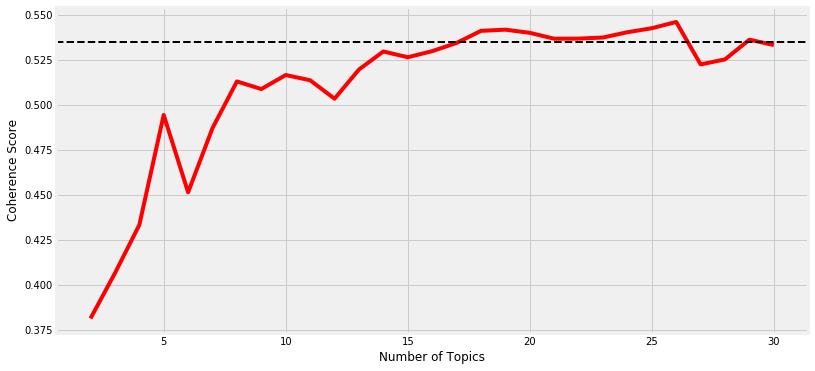

In [43]:
# Let’s plot a graph showing the number of topics per model and their corresponding coherence scores 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

# From Figure, it looks like the score starts increasing rapidly when the number of topics is five and gradually starts plateauing at 19 or 20. We choose the optimal number
# of topics as 20, based on our intuition

In [44]:
# We can retrieve the best model now
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

In [45]:
# Let’s view all the 20 topics generated by our selected best model, similar to our previous models
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['class', 'classification', 'classifier', 'training', 'pattern', 'feature', 'kernel', 'machine', 'training_set', 'test', 'sample', 'vector', 'database', 'error_rate', 'margin', 'experiment', 'support_vector', 'nearest_neighbor', 'decision', 'size']

Topic #2:
['neuron', 'memory', 'pattern', 'dynamic', 'connection', 'phase', 'attractor', 'capacity', 'state', 'hopfield', 'neural', 'fixed_point', 'oscillator', 'delay', 'stable', 'fig', 'oscillation', 'associative_memory', 'behavior', 'stored']

Topic #3:
['word', 'recognition', 'training', 'speech', 'character', 'context', 'hmm', 'letter', 'mlp', 'speaker', 'feature', 'frame', 'trained', 'speech_recognition', 'phoneme', 'experiment', 'hybrid', 'segmentation', 'vowel', 'level']

Topic #4:
['noise', 'rate', 'equation', 'curve', 'average', 'correlation', 'rule', 'distribution', 'theory', 'limit', 'solution', 'optimal', 'eq', 'teacher', 'effect', 'size', 'temperature', 'student', 'line', 'random']

Topic #5:
['bound', 'theorem', 'cl

In [46]:
# A better way of visualizing the topics is to build a term-topic dataframe
topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df
# Generated topics from our LDA topic model

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,class,neuron,word,noise,bound,vector,search,distribution,visual,neuron,state,node,image,control,unit,circuit,rule,vector,signal,prediction
Term2,classification,memory,recognition,rate,theorem,matrix,task,probability,motion,cell,sequence,tree,object,action,layer,chip,representation,map,filter,training
Term3,classifier,pattern,training,equation,class,linear,experiment,prior,cell,spike,step,structure,feature,state,training,current,module,distance,frequency,estimate
Term4,training,dynamic,speech,curve,probability,equation,table,gaussian,response,synaptic,recurrent,graph,pixel,policy,hidden_unit,analog,structure,cluster,source,regression
Term5,pattern,connection,character,average,size,solution,instance,variable,stimulus,activity,transition,code,face,environment,net,voltage,human,local,channel,test
Term6,feature,phase,context,correlation,threshold,gradient,test,mixture,direction,response,stochastic,level,view,controller,architecture,implementation,movement,dimension,noise,noise
Term7,kernel,attractor,hmm,rule,proof,constraint,domain,density,receptive_field,stimulus,iteration,bit,recognition,reinforcement_learning,pattern,processor,motor,clustering,component,selection
Term8,machine,capacity,letter,distribution,polynomial,convergence,target,bayesian,map,firing,update,path,representation,task,activation,bit,target,mapping,response,variance
Term9,training_set,state,mlp,theory,theory,optimization,query,estimate,spatial,synapsis,dynamic,local,shape,optimal,trained,design,language,dimensional,temporal,training_set
Term10,test,hopfield,speaker,limit,complexity,nonlinear,feature,approximation,orientation,et_al,probability,size,scale,robot,task,device,subject,region,sound,sample


In [88]:
# Another easy way to view the topics is to create a topic-term dataframe, whereby each topic is represented in a row
# with the terms of the topic being represented as a comma-separated string.
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df
# Viewing all the topics of our LDA topic model
# The dataframe depicted in Figure gives us an easy way to visualize and understand the major themes in our corpus
# of research papers

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'topics' is not defined

# Interpreting Topic Model Results
Let’s look at some interesting ways of diving deeper and interpreting results from our topic model. An interesting point to remember is, given a corpus of documents (in the form of features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of topics in each document (research paper in this case) with the following code.

tm_results = best_lda_model

In [89]:
tm_results = best_lda_model[bow_corpus]

NameError: name 'best_lda_model' is not defined

In [49]:
# We can now get the most dominant topic per research paper with some intelligent sorting and indexing using the following code
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(16, 0.2115988756613756),
 (5, 0.29989652050187554),
 (9, 0.3307915758896151),
 (8, 0.5447463768115942),
 (9, 0.18093823158652983)]

In [50]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

## Dominant Topics Distribution across Corpus
Let’s now take a look at various ways we can transform these results and extract meaningful insights from our research papers and their topics.

In [51]:
# The first thing we can do is look at the overall distribution of each topic across the corpus of research papers.
pd.set_option('display.max_colwidth', 200)
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg({
                                                'Dominant Topic': {
                                                    'Doc Count': np.size,
                                                    '% Total Docs': np.size }
                                              })
topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()
topic_stats_df['% Total Docs'] = topic_stats_df['% Total Docs'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]
topic_stats_df
# Viewing the distribution of dominant topics

/home/paperspace/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,Dominant Topic,Doc Count,% Total Docs,Topic Desc
0,1,75,4.31,"class, classification, classifier, training, pattern, feature, kernel, machine, training_set, test, sample, vector, database, error_rate, margin, experiment, support_vector, nearest_neighbor, deci..."
1,2,69,3.97,"neuron, memory, pattern, dynamic, connection, phase, attractor, capacity, state, hopfield, neural, fixed_point, oscillator, delay, stable, fig, oscillation, associative_memory, behavior, stored"
2,3,78,4.48,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level"
3,4,68,3.91,"noise, rate, equation, curve, average, correlation, rule, distribution, theory, limit, solution, optimal, eq, teacher, effect, size, temperature, student, line, random"
4,5,105,6.03,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded"
5,6,80,4.60,"vector, matrix, linear, equation, solution, gradient, constraint, convergence, optimization, nonlinear, optimal, eq, minimum, operator, gradient_descent, condition, constant, derivative, quadratic..."
6,7,66,3.79,"search, task, experiment, table, instance, test, domain, target, query, feature, user, random, technique, run, accuracy, block, application, evaluation, strategy, important"
7,8,148,8.51,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent..."
8,9,117,6.72,"visual, motion, cell, response, stimulus, direction, receptive_field, map, spatial, orientation, unit, eye, field, activity, location, velocity, center, contrast, cortical, pattern"
9,10,141,8.10,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate"


## Dominant Topics in Specific Research Papers
Another interesting perspective is to select specific papers, view the most dominant topic
in each of those papers, and see if that makes sense.

In [52]:
# Viewing the dominance of topics in research papers
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([681, 9, 392, 1622, 17, 
                        906, 996, 503, 13, 733])])

# they make perfect sense! This tells us that our topic model is working well.

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
9,9,13,29.10,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","622 \nLEARNING A COLOR ALGORITHM FROM EXAMPLES \nAnya C. Hurlbert and Tomaso A. Poggio \nArtificial Intelligence Laboratory and Department of Brain and Cognitive Sciences, \nMassachusetts Institut..."
13,13,16,27.12,"circuit, chip, current, analog, voltage, implementation, processor, bit, design, device, computation, parallel, digital, operation, array, neural, synapse, element, hardware, transistor","9 \nStochastic Learning Networks and their Electronic Implementation \nJoshua Alspector*, Robert B. Allen, Victor Hut, and Srinagesh Satyanarayana \nBell Communications Research, Morristown, NJ 0..."
17,17,5,23.00,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","338 \nThe Connectivity Analysis of Simple Association \nHow Many Connections Do You Need? \nDan Hammerstrom * \nOregon Graduate Center, Beaverton, OR 97006 \nABSTRACT \nThe efficient realization, ..."
392,392,14,67.03,"control, action, state, policy, environment, controller, reinforcement_learning, task, optimal, robot, goal, step, reward, td, agent, adaptive, cost, reinforcement, trial, exploration","Integrated Modeling and Control \nBased on Reinforcement Learning \nand Dynamic Programming \nRichard S. Sutton \nGTE Laboratories Incorporated \nWaltham, MA 02254 \nAbstract \nThis is a summary o..."
503,503,3,60.76,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Multi-State Time Delay Neural Networks \nfor Continuous Speech Recognition \nPatrick Haffner \nCNET Lannion A TSS/RCP \n22301 LANNION, FRANCE \nhaffnerlannion.cnet. fr \nAlex Waibel \nCarnegie Me..."
681,681,3,67.58,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Connected Letter Recognition with a \nMulti-State Time Delay Neural Network \nHermann Hild and Alex Waibel \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213-3891, US..."
733,733,16,45.55,"circuit, chip, current, analog, voltage, implementation, processor, bit, design, device, computation, parallel, digital, operation, array, neural, synapse, element, hardware, transistor","High Performance Neural Net Simulation \non a Multiprocessor System with \n""Intelligent"" Communication \nUrs A. Miiller, Michael Kocheisen, and Anton Gunzinger \nElectronics Laboratory, Swiss Fede..."
906,906,10,56.44,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate","A model of the hippocampus combining self- \norganization and associative memory function. \nMichael E. Hasselmo, Eric Schnell \nJoshua Berke and Edi Barkai \nDept. of Psychology, Harvard Universi..."
996,996,19,65.69,"signal, filter, frequency, source, channel, noise, component, response, temporal, sound, auditory, detection, phase, ica, adaptation, amplitude, subject, eeg, change, correlation","Using Feedforward Neural Networks to \nMonitor Alertness from Changes in EEG \nCorrelation and Coherence \nScott Makeig \nNaval Health Research Center, P.O. Box 85122 \nSan Diego, CA 92186-5122 \n..."
1622,1622,8,56.70,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent...","The Infinite Gaussian Mixture Model \nCarl Edward Rasmussen \nDepartment of Mathematical Modellin

## Relevant Research Papers per Topic based on Dominance
A better way of representation is to try to retrieve the corresponding research paper that
has the highest representation for each of the 20 topics.

In [53]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], 
                                                                                         ascending=False)
                                                                             .iloc[0]))

# Viewing each topic and corresponding paper with its maximum contribution
# It looks like our model has captured the relevant latent patterns and themes in our corpus

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
Dominant Topic,,,,,
1,1138,1,61.01,"class, classification, classifier, training, pattern, feature, kernel, machine, training_set, test, sample, vector, database, error_rate, margin, experiment, support_vector, nearest_neighbor, deci...","Improving the Accuracy and Speed of \nSupport Vector Machines \nChris J.C. Burges \nBell Laboratories \nLucent Technologies, Room 3G429 \n101 Crawford's Corner Road \nHolmdel, NJ 07733-3030 \nburg..."
2,131,2,56.71,"neuron, memory, pattern, dynamic, connection, phase, attractor, capacity, state, hopfield, neural, fixed_point, oscillator, delay, stable, fig, oscillation, associative_memory, behavior, stored","568 \nDYNAMICS OF ANALOG NEURAL \nNETWORKS WITH TIME DELAY \nC.M. Marcus and R.M. Westervelt \nDivision of Applied Sciences and Department of Physics \nHarvard University, Cambridge Massachusetts ..."
3,681,3,67.58,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Connected Letter Recognition with a \nMulti-State Time Delay Neural Network \nHermann Hild and Alex Waibel \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213-3891, US..."
4,1570,4,73.69,"noise, rate, equation, curve, average, correlation, rule, distribution, theory, limit, solution, optimal, eq, teacher, effect, size, temperature, student, line, random","Dynamics of Supervised Learning with \nRestricted Training Sets \nA.C.C. Coolen \nDept of Mathematics \nKing's College London \nStrand, London WC2R 2LS, UK \ntcoolen @mth.kcl.ac.uk \nD. Saad \nNeu..."
5,431,5,81.06,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","Polynomial Uniform Convergence of \nRelative Frequencies to Probabilities \nAlberto Bertoni, Paola Campadelll;' Anna Morpurgo, Sandra Panlzza \nDipartimento di Scienze dell'Informazione \nUniversi..."
6,82,6,57.12,"vector, matrix, linear, equation, solution, gradient, constraint, convergence, optimization, nonlinear, optimal, eq, minimum, operator, gradient_descent, condition, constant, derivative, quadratic...","612 \nConstrained Differential Optimization \nJohn C. Platt \nAlan H. Ban' \nCalifornia Institute of Technology, Pasadena, CA 91125 \nAbstract \nMany optimization models of neural networks need co..."
7,741,7,62.82,"search, task, experiment, table, instance, test, domain, target, query, feature, user, random, technique, run, accuracy, block, application, evaluation, strategy, important","When Will a Genetic Algorithm \nOutperform Hill Climbing? \nMelanie Mitchell \nSanta Fe Institute \n1660 Old Pecos Trail, Suite A \nSanta Fe, NM 87501 \nJohn H. Holland \nDept. of Psychology \nUni..."
8,1375,8,61.11,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, ent...",Approximating Posterior Distributions \nin Belief Networks using Mixtures \nChristopher M. Bishop \nNeil Lawrence \nNeural Computing Research Group \nDept. Computer Science & Applied Mathematics \...
9,808,9,66.59,"visual, motion, cell, response, stimulus, direction, receptive_field, map, spatial, orientation, unit, eye, field, activity, location, velocity, center, contrast, cortical, pattern","Development of Orientation and Ocular \nDominance Columns in Infant Macaques \nKlaus Obermayer \nHoward Hughes Medical Institute \nSMk-Institute \nLa Jolla, CA 92037 \nLynne Kiorpes \nCenter for N..."


# Predicting Topics for New Research Papers
Even though topic models are unsupervised models, we can estimate or predict
potential topics for new documents based on what it has learned previously on the so-called “training” corpus!!!

In [9]:
import glob
# papers manually downloaded from NIPS 16
# https://papers.nips.cc/book/advances-in-neural-information-processing-systems-29-2016

new_paper_files = glob.glob('test_data/nips16*.txt')
new_papers = []
for fn in new_paper_files:
    with open(fn, encoding='utf-8', errors='ignore', mode='r+') as f:
        data = f.read()
        new_papers.append(data)
              
print('Total New Papers:', len(new_papers))

Total New Papers: 4


In [5]:
# We need to build a text wrangling and feature engineering pipeline, which should
# match the same steps we followed when training our topic model
def text_preprocessing_pipeline(documents, normalizer_fn, bigram_model):
    norm_docs = normalizer_fn(documents)
    norm_docs_bigrams = bigram_model[norm_docs]
    return norm_docs_bigrams

def bow_features_pipeline(tokenized_docs, dictionary):
    paper_bow_features = [dictionary.doc2bow(text) 
                              for text in tokenized_docs]
    return paper_bow_features

norm_new_papers = text_preprocessing_pipeline(documents=new_papers, normalizer_fn=normalize_corpus, 
                                              bigram_model=bigram_model)
norm_bow_features = bow_features_pipeline(tokenized_docs=norm_new_papers, dictionary=dictionary)

NameError: name 'bigram_model' is not defined

In [68]:
# We can now validate if the transformations worked with the following code.
print(norm_new_papers[0][:30])

['cooperative', 'graphical_model', 'josip', 'djolonga', 'dept_computer', 'science', 'eth', 'zurich', 'josipd', 'inf', 'ethz', 'ch', 'stefanie', 'jegelka', 'csail', 'mit', 'stefje', 'mit_edu', 'sebastian', 'tschiatschek', 'dept_computer', 'science', 'eth', 'zurich', 'stschia', 'inf', 'ethz', 'ch', 'andreas', 'krause']


In [69]:
print(norm_bow_features[0][:30])

[(0, 1), (1, 1), (6, 1), (17, 1), (18, 1), (19, 1), (25, 1), (31, 2), (36, 2), (38, 1), (39, 17), (41, 3), (43, 1), (45, 1), (49, 2), (50, 4), (51, 1), (52, 2), (54, 1), (60, 1), (65, 1), (66, 3), (68, 7), (71, 8), (76, 4), (77, 2), (87, 1), (88, 3), (105, 1), (106, 1)]


In [70]:
# Let’s now build a generic function that can extract the top N topics from any research
# paper using our trained model.
def get_topic_predictions(topic_model, corpus, topn=3):
    topic_predictions = topic_model[corpus]
    best_topics = [[(topic, round(wt, 3)) 
                        for topic, wt in sorted(topic_predictions[i], 
                                                key=lambda row: -row[1])[:topn]] 
                            for i in range(len(topic_predictions))]
    return best_topics

In [71]:
# We get the top two topics for each research paper because a paper or document
# can always be a mixture of multiple topics...
topic_preds = get_topic_predictions(topic_model=best_lda_model, 
                                    corpus=norm_bow_features, topn=2)
topic_preds

[[(7, 0.241), (4, 0.199)],
 [(13, 0.293), (4, 0.248)],
 [(12, 0.238), (9, 0.113)],
 [(2, 0.263), (12, 0.145)]]

In [72]:
# Let’s view the results for each paper in an easy-to-understand format.
results_df = pd.DataFrame()
results_df['Papers'] = range(1, len(new_papers)+1)
results_df['Dominant Topics'] = [[topic_num+1 for topic_num, wt in item] for item in topic_preds]
res = results_df.set_index(['Papers'])['Dominant Topics'].apply(pd.Series).stack().reset_index(level=1, drop=True)
results_df = pd.DataFrame({'Dominant Topics': res.values}, index=res.index)
results_df['Contribution %'] = [topic_wt for topic_list in 
                                        [[round(wt*100, 2) 
                                              for topic_num, wt in item] 
                                                 for item in topic_preds] 
                                    for topic_wt in topic_list]

results_df['Topic Desc'] = [topics_df.iloc[t-1]['Terms per Topic'] for t in results_df['Dominant Topics'].values]
results_df['Paper Desc'] = [new_papers[i-1][:200] for i in results_df.index.values]

In [73]:
# Predicting topics for new papers with our LDA model
pd.set_option('display.max_colwidth', 300)
results_df

,Dominant Topics,Contribution %,Topic Desc,Paper Desc
Papers,,,,
1,8,24.1,"distribution, probability, prior, gaussian, variable, mixture, density, bayesian, estimate, approximation, log, likelihood, sample, component, expert, em, posterior, probabilistic, estimation, entropy","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer Science, ETH"
1,5,19.9,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","Cooperative Graphical Models\nJosip Djolonga\nDept. of Computer Science, ETH Zurich ¨\njosipd@inf.ethz.ch\nStefanie Jegelka\nCSAIL, MIT\nstefje@mit.edu\nSebastian Tschiatschek\nDept. of Computer Science, ETH"
2,14,29.3,"control, action, state, policy, environment, controller, reinforcement_learning, task, optimal, robot, goal, step, reward, td, agent, adaptive, cost, reinforcement, trial, exploration","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York, NY 10011\na"
2,5,24.8,"bound, theorem, class, probability, size, threshold, proof, polynomial, theory, complexity, loss, approximation, linear, assume, definition, defined, hypothesis, constant, define, bounded","PAC Reinforcement Learning with Rich Observations\nAkshay Krishnamurthy\nUniversity of Massachusetts, Amherst\nAmherst, MA, 01003\nakshay@cs.umass.edu\nAlekh Agarwal\nMicrosoft Research\nNew York, NY 10011\na"
3,13,23.8,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\nUniversit"
3,10,11.3,"neuron, cell, spike, synaptic, activity, response, stimulus, firing, synapsis, et_al, effect, neural, neuronal, current, pattern, inhibitory, connection, brain, simulation, firing_rate","Automated scalable segmentation of neurons from\nmultispectral images\nUygar Sümbül\nGrossman Center for the Statistics of Mind\nand Dept. of Statistics, Columbia University\nDouglas Roossien Jr.\nUniversit"
4,3,26.3,"word, recognition, training, speech, character, context, hmm, letter, mlp, speaker, feature, frame, trained, speech_recognition, phoneme, experiment, hybrid, segmentation, vowel, level","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute of Tech"
4,13,14.5,"image, object, feature, pixel, face, view, recognition, representation, shape, scale, part, visual, region, position, scene, surface, vision, frame, texture, location","Unsupervised Learning of Spoken Language with\nVisual Context\nDavid Harwath, Antonio Torralba, and James R. Glass\nComputer Science and Artificial Intelligence Laboratory\nMassachusetts Institute of Tech"
